In [1]:
#hide
#all_examples

# Using fastai for segmentation

In this example, we use U-net for segmenting the areas containing swamps and marshes from historical printed maps. 

In [2]:
from pathlib import Path
from drone_detector.processing.tiling import *
import os
from fastai.vision.all import *
from drone_detector.engines.fastai.data import *

In [3]:
outpath = Path('../data/historic_map/processed/raster_tiles/')

fnames = [Path(outpath/f) for f in os.listdir(outpath)]

dls = SegmentationDataLoaders.from_label_func('../data/historic_map/', bs=16,
                                              codes=['Marshes'],
                                              fnames=fnames,
                                              label_func=partial(label_from_different_folder,
                                                                 original_folder='raster_tiles',
                                                                 new_folder='mask_tiles'),
                                              batch_tfms = [
                                                  *aug_transforms(max_rotate=0., max_warp=0.),
                                                  Normalize.from_stats(*imagenet_stats)
                                              ])

/opt/conda/lib/python3.9/site-packages/torch/_tensor.py:1142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


`label_from_different_folder` is a helper located in `drone_detector.engines.fastai.data`. That module also contains helpers to use with for instance multispectral images or time series of images.

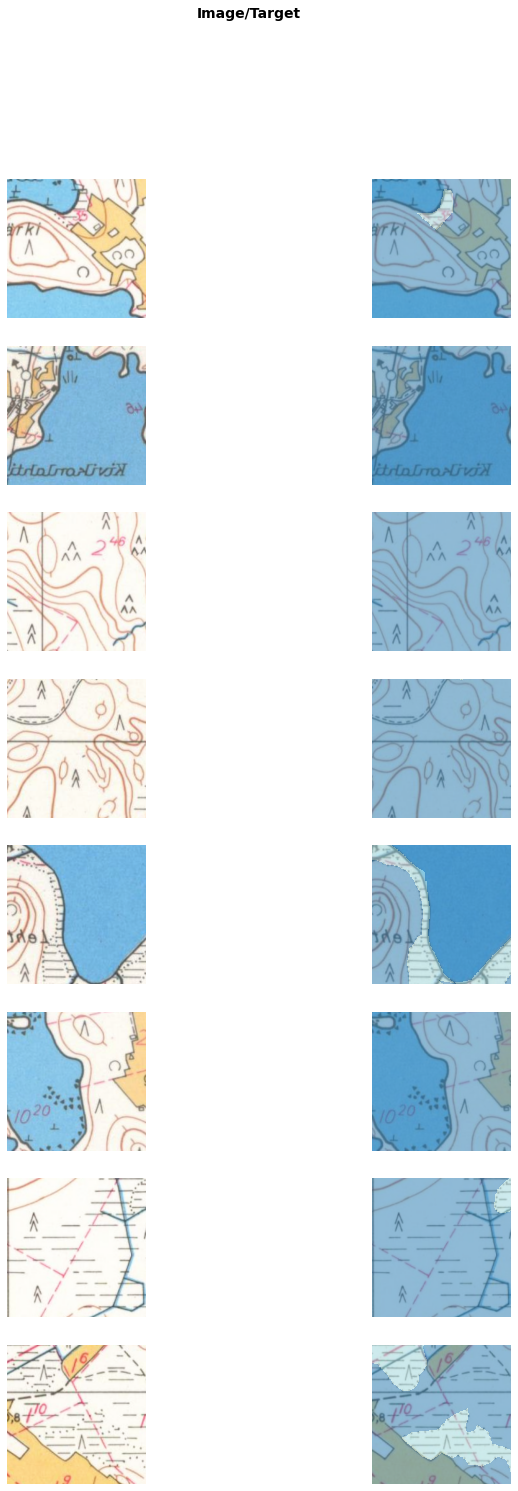

In [4]:
dls.show_batch(max_n=16)

Train basic U-Net, using pretrained Resnet50 as the encoder. `to_fp16()` tells our model to use half precision training, thus using less memory. Loss function is `FocalLossFlat`, and for segmentation we need to specify `axis=1`. Metrics are `Dice` and `JaccardCoeff`, fairly standard segmentation metrics.

In [5]:
learn = unet_learner(dls, resnet50, pretrained=True, n_in=3, n_out=2,
                     metrics=[Dice(), JaccardCoeff()], loss_func=FocalLossFlat(axis=1)
                    ).to_fp16()

Search for a suitable learning rate.

SuggestedLRs(valley=3.630780702224001e-05)

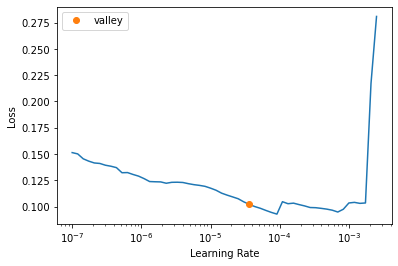

In [6]:
learn.lr_find()

Train the model for 2 epochs with encoder layers frozen and 10 epochs with all layers unfrozen.

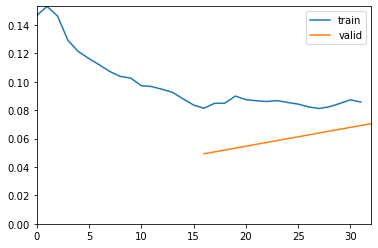

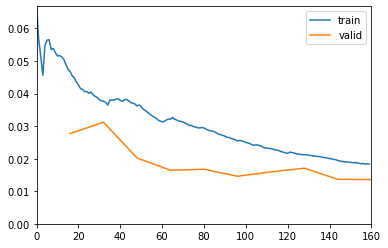

In [7]:
from fastai.callback.progress import ShowGraphCallback
learn.fine_tune(10, freeze_epochs=2, base_lr=1e-4, cbs=ShowGraphCallback)

Return to full precision.

In [8]:
learn.to_fp32()

Check results.

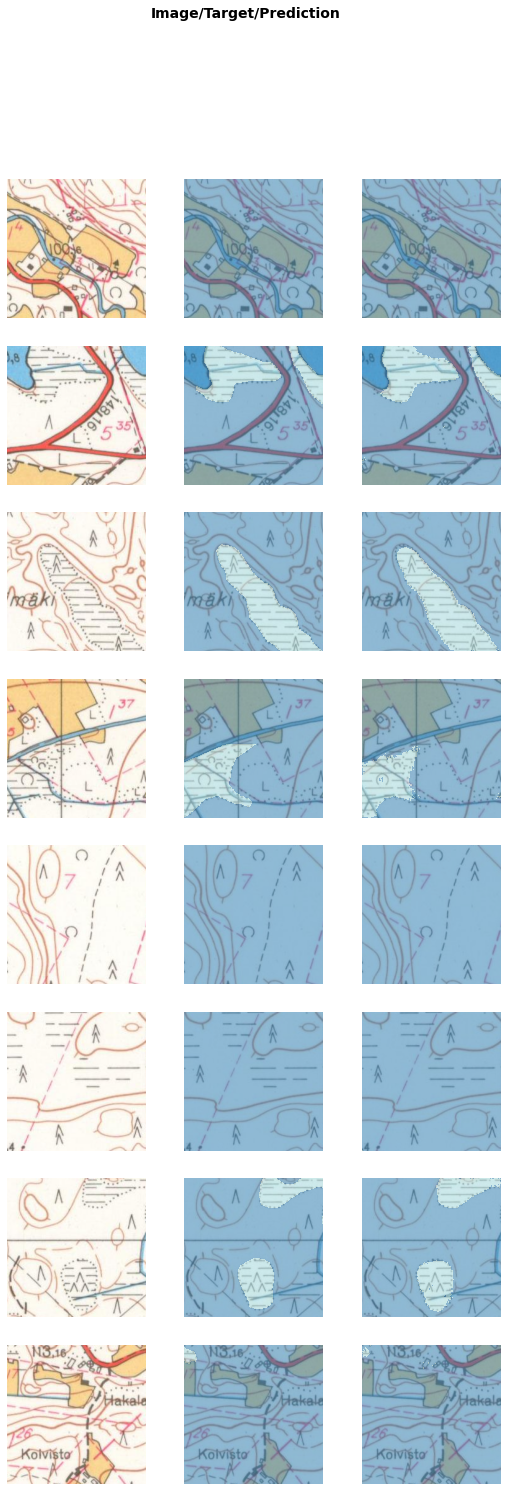

In [9]:
learn.show_results(max_n=8)

In [10]:
preds = learn.get_preds(with_input=False, with_decoded=False)

Export the model to use later.

In [11]:
learn.path = Path('../data/historic_map/models')
learn.export('resnet50_focalloss_swamps.pkl')

Some helper functions for inference, such as removing all resizing transforms.

In [5]:
def label_func(fn):
    return str(fn).replace('raster_tiles', 'mask_tiles')

@patch 
def remove(self:Pipeline, t):
    for i,o in enumerate(self.fs):
        if isinstance(o, t.__class__): self.fs.pop(i)
            
@patch
def set_base_transforms(self:DataLoader):
    attrs = ['after_item', 'after_batch']
    for i, attr in enumerate(attrs):
        tfms = getattr(self, attr)
        for j, o in enumerate(tfms):
            if hasattr(o, 'size'):
                tfms.remove(o)
            setattr(self, attr, tfms)

Load learners and remove all resizing transforms. If you run out of memory just restart the kernel.

In [6]:
testlearn = load_learner('../data/historic_map/models/resnet50_focalloss_swamps.pkl', cpu=False)
testlearn.dls.valid.set_base_transforms()

The model is tested with 3 different map patches from different areas and sizes. Two of the images are from 1965 and two from 1984. Image sizes vary between 600x600 and 1500x1500 pixels.

In [7]:
import PIL
def unet_predict(fn):
    image = np.array(PIL.Image.open(fn))
    mask = testlearn.predict(PILImage.create(image))[0].numpy()
    img = image
    img[:,:,0][mask==0] = 0
    img[:,:,1][mask==0] = 0
    img[:,:,2][mask==0] = 0
    img = PIL.Image.fromarray(img.astype(np.uint8))
    return img

In [8]:
test_images = [f'../data/historic_map/test_patches/{f}' for f in os.listdir('../data/historic_map/test_patches/')]

First result.

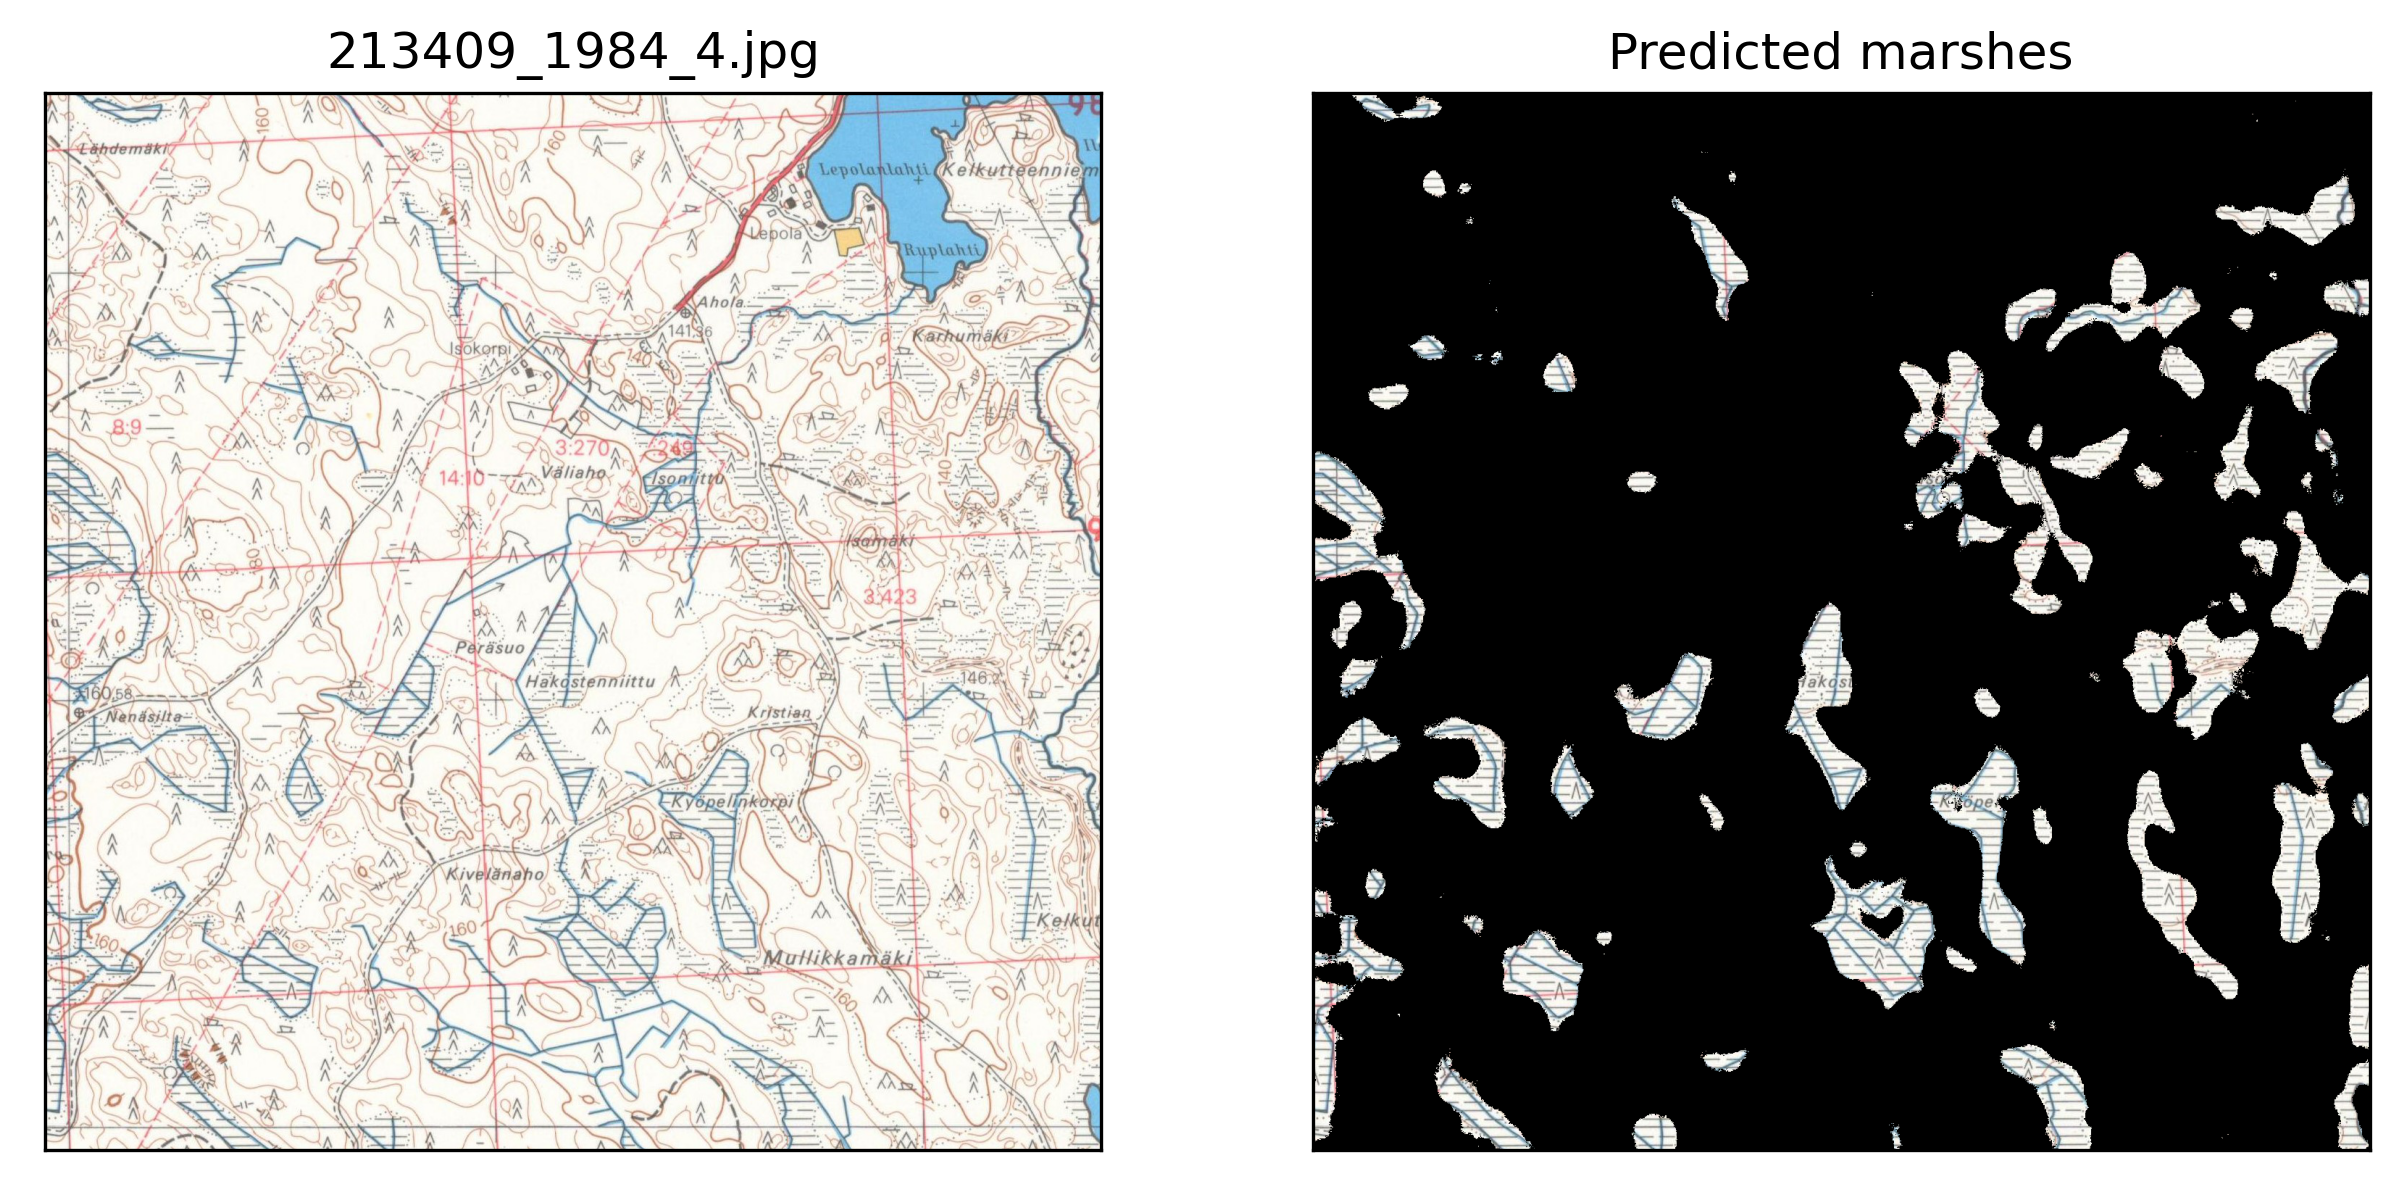

In [9]:
patch_pred = unet_predict(test_images[0])

fig, axs = plt.subplots(1,2, figsize=(10,5),dpi=300)
for a in axs:
    a.set_yticks([])
    a.set_xticks([])
axs[0].imshow(PIL.Image.open(test_images[0]))
axs[1].imshow(patch_pred)
axs[0].set_title(test_images[0].split('/')[-1])
axs[1].set_title('Predicted marshes')
plt.show()

Second result

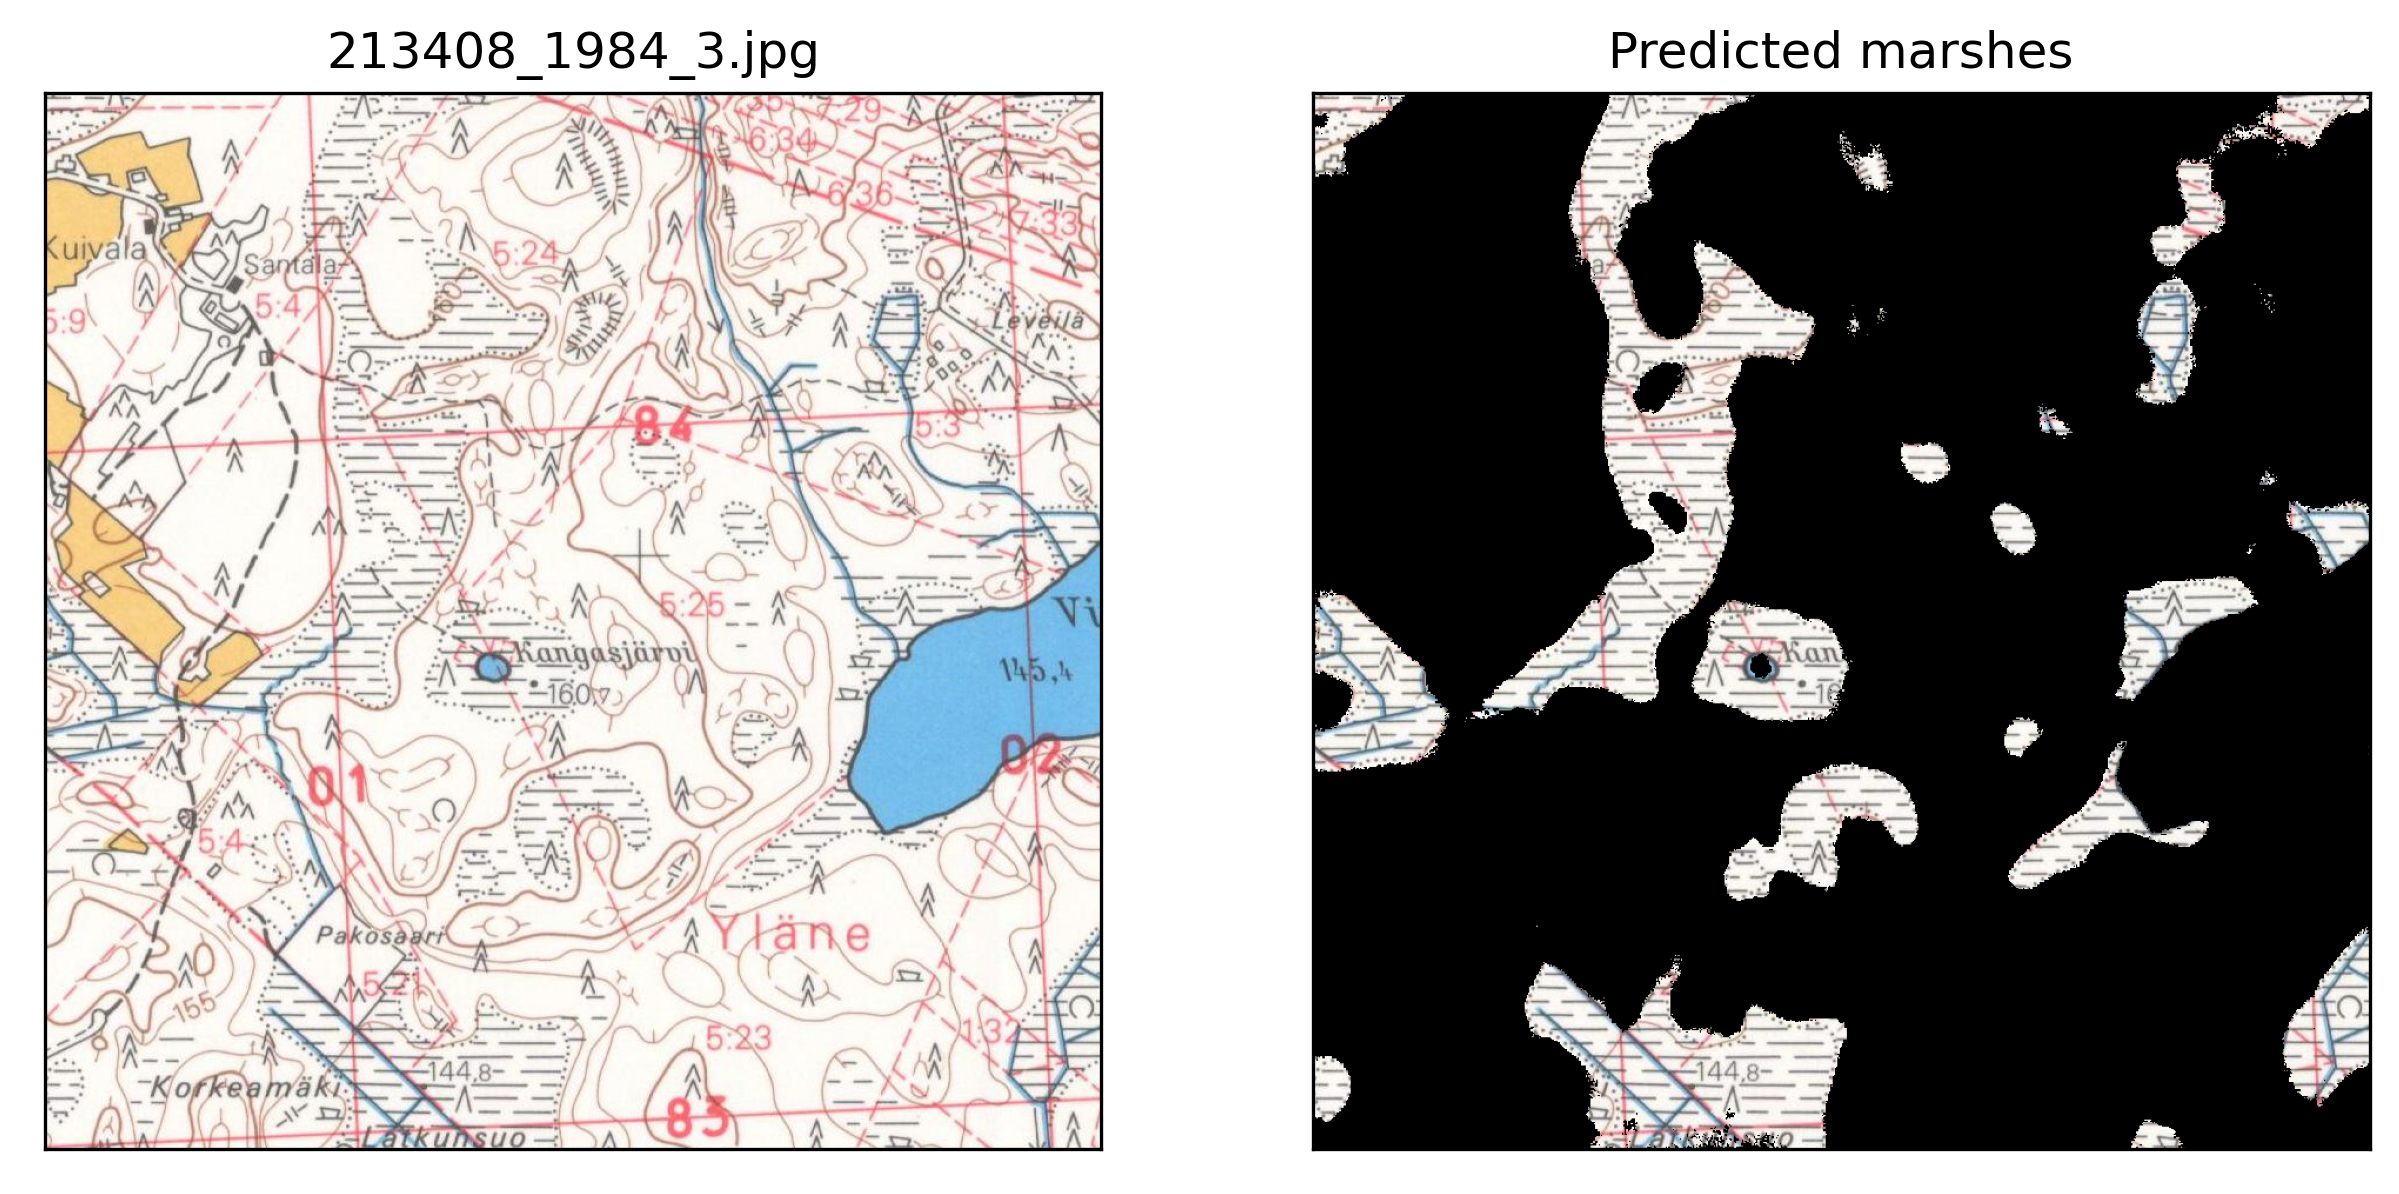

In [10]:
patch_pred = unet_predict(test_images[1])

fig, axs = plt.subplots(1,2, figsize=(10,5),dpi=300)
for a in axs:
    a.set_yticks([])
    a.set_xticks([])
axs[0].imshow(PIL.Image.open(test_images[1]))
axs[1].imshow(patch_pred)
axs[0].set_title(test_images[1].split('/')[-1])
axs[1].set_title('Predicted marshes')
plt.show()

Third result

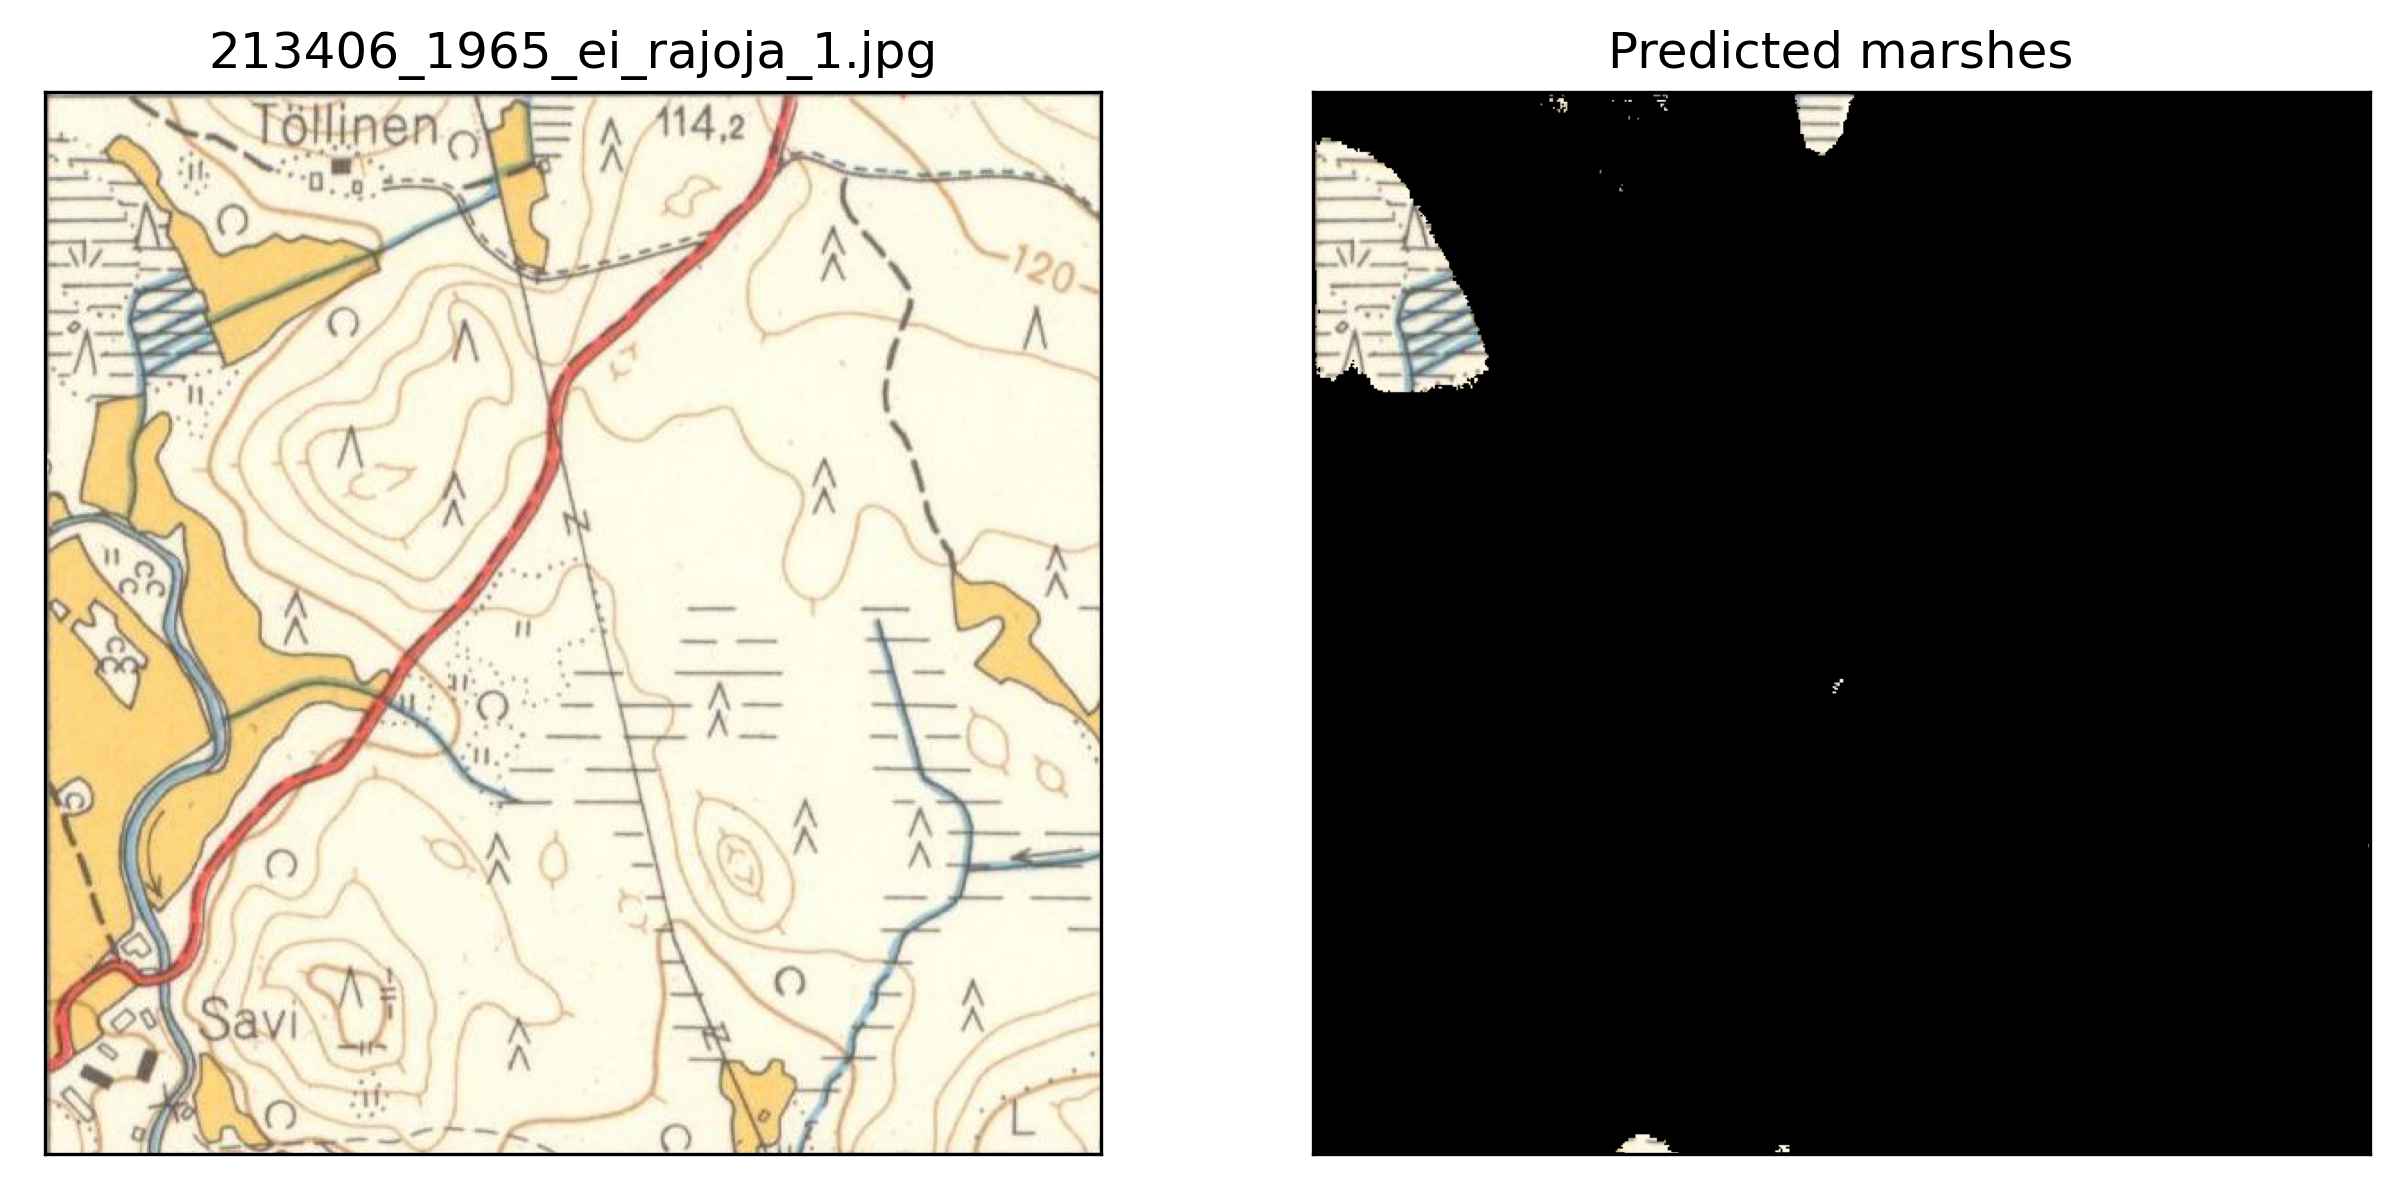

In [12]:
patch_pred = unet_predict(test_images[3])

fig, axs = plt.subplots(1,2, figsize=(10,5),dpi=300)
for a in axs:
    a.set_yticks([])
    a.set_xticks([])
axs[0].imshow(PIL.Image.open(test_images[3]))
axs[1].imshow(patch_pred)
axs[0].set_title(test_images[3].split('/')[-1])
axs[1].set_title('Predicted marshes')
plt.show()

In [13]:
# hide

from nbdev.export import notebook2script
notebook2script()
!nbdev_build_docs

Converted 00_utils.ipynb.
Converted 01_metrics.ipynb.
Converted 10_processing.tiling.ipynb.
Converted 11_processing.coordinates.ipynb.
Converted 12_processing.coco.ipynb.
Converted 13_processing.postprocessing.ipynb.
Converted 30_engines.fastai.data.ipynb.
Converted 31_engines.fastai.losses.ipynb.
Converted 32_engines.fastai.augmentations.ipynb.
Converted 33_engines.fastai.predict.ipynb.
Converted 40_engines.detectron2.predict.ipynb.
Converted 41_engines.detectron2.training.ipynb.
Converted 42_engines.detectron2.augmentations.ipynb.
Converted 43_engines.detectron2.tta.ipynb.
Converted examples.fastai.segmentation.ipynb.
Converted examples.tiling.ipynb.
Converted index.ipynb.
Converted overview.engines.ipynb.
converting: /scratch/deadwood/drone_detector/nbs/10_processing.tiling.ipynb
converting: /scratch/deadwood/drone_detector/nbs/examples.fastai.segmentation.ipynb
converting /scratch/deadwood/drone_detector/nbs/index.ipynb to README.md
